# Evolution of Einstein's equations

# Initial data constants definition

# Initial data , setting length of the domain and discretization


In [197]:
# Parameters
m = 1

2

In [198]:
res=m;
N=2.0^m*500.0;#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.8


In [199]:
print(N)

2000.0

In [200]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.0005
dt =0.0002
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [201]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2"

In [202]:
println(dx)
println(dt)

0.0005
0.0002


In [203]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [204]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [205]:
print(dx)
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)

0.0005step size is  0.0005
the time step is 0.0002


In [206]:
radius=zeros(L)
print(L)
print(size(initX1))
print(initX1[1001])
for i in 1:L
    radius[i]=initX[i]/(1-initX[i])
end


2007(2001,)0.5

In [207]:
include("./ScalarField.jl");

In [208]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [209]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initphi=zeros(L);
initphibar=zeros(L);

#PHI,X

r0=0.3
sigma=0.3
A=0.1449
initphibar[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)



#PHI FROM PSI,X
spl = scipyinterpolate.splrep(initX[4:L-3], initphibar[4:L-3],k=5)
phi0=0
SFconstraint_phi_new(phi0,x) = scipyinterpolate.splev(x, spl)
initphi[4:L-3] = rungekutta4(SFconstraint_phi_new,phi0,initX1)#,state_array[4:L-3,:])


#PHI
"initphi = init_gaussian(R,r0,sigma,A)"




"initphi = init_gaussian(R,r0,sigma,A)"

In [210]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX, [initphi initphibar], xaxis="x",title="Initial Data", labels=["init phi" "init phi,x"])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX, [initphi initphibar], xaxis=\"x\",title=\"Initial Data\", labels=[\"init phi\" \"init phi,x\"])"

In [211]:
initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar initX];


#PSI
initpsi = initphi .* initX ./ (1 .- initX)
initpsi[L-3]=0
state_array[:,3]=initpsi;
state_array=ghost(state_array);


#PSI,X
initpsibar = initphibar .* initX ./ (1 .- initX) +  initphi ./ (1 .- initX) .^2
initpsibar[L-3]=0
state_array[:,4]=initpsibar;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)

beta_func(x) = m_func(x)

spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
psi_func(x) = scipyinterpolate.splev(x, spl_psi)

spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,4],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

spl_funcs = [m_func beta_func psi_func derpsi_func]

#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,spl_funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);

#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,spl_funcs)
state_array[:,1]=initm;
state_array=ghost(state_array);

spl_m = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)
spl_funcs[1] = m_func

spl_beta = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,2],k=4)
beta_func(x) = scipyinterpolate.splev(x, spl_beta)
spl_funcs[2] = beta_func

beta_func (generic function with 1 method)

In [212]:
"""using Plots #showing initial data and the initial status of the horizon finder
plot(initX, [initpsi initpsibar], xaxis="x",title="Initial Data", labels=["init psi" "init psi,x"])"""

"using Plots #showing initial data and the initial status of the horizon finder\nplot(initX, [initpsi initpsibar], xaxis=\"x\",title=\"Initial Data\", labels=[\"init psi\" \"init psi,x\"])"

In [213]:
#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio = 2*state_array[:,1]/initX[i]*(1-initX[i])
    if monitor_ratio[i]>0.6
        print(monitor_ratio[i])
    end
end

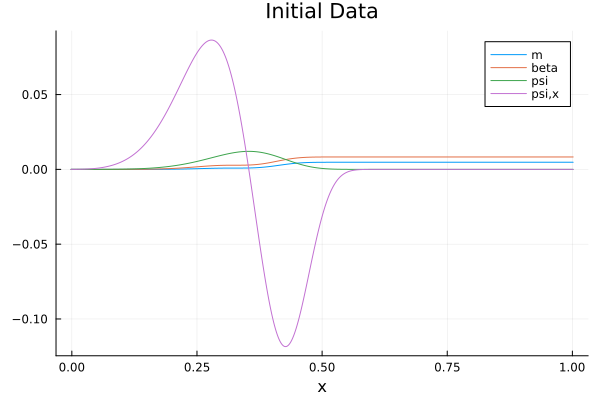

In [214]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [215]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2/time_step0.csv"

 ## Time evolution

In [216]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0,spl_funcs) #evolve psi,x
    state_array=ghost(state_array)
    
    X=state_array[:,5]
    X1=X[4:L-3]
    
    spl_derpsi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,4],k=4)
    derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)
    spl_funcs[4] = derpsi_func
    
    #calculate psi form psi,x
    psi0=0
    SFconstraint_psi(psi0,x) = derpsi_func(x)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,X1)
    state_array=ghost(state_array);
    
    spl_psi = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,3],k=4)
    psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    spl_funcs[3] = psi_func
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_beta = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,2],k=4)
    beta_func(x) = scipyinterpolate.splev(x, spl_beta)
    spl_funcs[2] = beta_func
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,X1,T,spl_funcs)
    state_array=ghost(state_array)
    
    spl_m = scipyinterpolate.splrep(X[4:L-3], state_array[4:L-3,1],k=4)
    m_func(x) = scipyinterpolate.splev(x, spl_m)
    spl_funcs[1] = m_func
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

Progress:   0%|▏                                        |  ETA: 2:07:18

LoadError: InterruptException:

In [136]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3

## Movie of the evolution

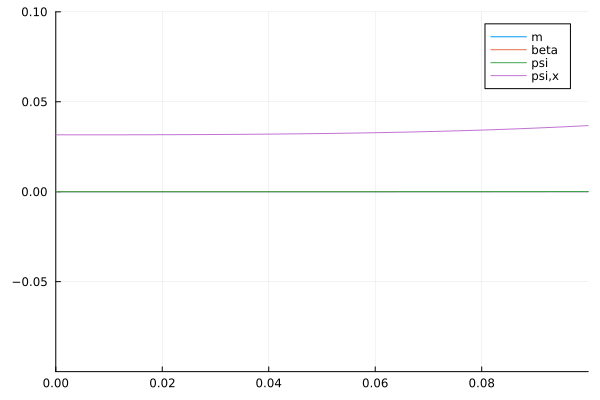

In [22]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:1:300#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    d=round(T[n],digits=1)
    #plot!(X1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.1,0.1], xlim=[0, 0.1]) |> display 
    plot!(plot5, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.1,0.1], xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1)

In [ ]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:1:300#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot5=functions3.Column5[4:L-3];
    d=round(T[n],digits=1)
    plot!(initX[4:L-3], plot5, labels=["R"],ylim=[0,1], xlim=[0, 1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 1)

In [219]:
print(state_array[4:L-3,1])

[0.0, 1.7155111079800898e-15, 1.3292807568856285e-14, 4.3417949727444515e-14, 9.951675381480386e-14, 1.8778238388314974e-13, 3.1320635918121184e-13, 4.796130984237428e-13, 6.896981373324279e-13, 9.450701549639791e-13, 1.2462969490093538e-12, 1.5929555030527819e-12, 1.9836862923027535e-12, 2.416251977648481e-12, 2.8876006413723167e-12, 3.3939337213434473e-12, 3.930778804081855e-12, 4.493067440687951e-12, 5.075218153297012e-12, 5.6712248034319264e-12, 6.274750497394812e-12, 6.879227207659938e-12, 7.477961293101813e-12, 8.064245104820337e-12, 8.631474868304148e-12, 9.173275036706254e-12, 9.68362931409273e-12, 1.0157018551663142e-11, 1.0588565724137893e-11, 1.097418819774978e-11, 1.1310757505579545e-11, 1.15962668503263e-11, 1.18300065590105e-11, 1.2012747718565072e-11, 1.2146934225782316e-11, 1.2236883489647924e-11, 1.2288996028711214e-11, 1.2311974210807725e-11, 1.2317050387172732e-11, 1.2318224677755593e-11, 1.233251266936897e-11, 1.2380203293181411e-11, 1.2485127152987234e-11, 1.267493

 0.0002466650723282082, 0.00024991777084167787, 0.0002531960549928226, 0.0002564997949885128, 0.00025982885315052666, 0.00026318308382605016, 0.0002665623332997392, 0.00026996643970742326, 0.00027339523295153096, 0.00027684853461831777, 0.0002803261578969796, 0.000283827907500734, 0.0002873535795899549, 0.0002909029616974444, 0.0002944758326559291, 0.0002980719625278682, 0.0003016911125376598, 0.0003053330350063364, 0.0003089974732888378, 0.0003126841617139525, 0.000316392825527019, 0.0003201231808354788, 0.0003238749345573738, 0.00032764778437288183, 0.0003314414186789841, 0.000335255516547359, 0.00033908974768559805, 0.00034294377240183885, 0.00034681724157291165, 0.0003507097966160963, 0.0003546210694645856, 0.00035855068254675324, 0.0003624982487693231, 0.0003664633715045382, 0.0003704456445814264, 0.00037444465228126154, 0.0003784599693373177, 0.00038249116093901444, 0.0003865377827405512, 0.0003905993808741286, 0.00039467549196785413, 0.0003987656431684297, 0.0004028693521687179,

, 0.0042059421107845775, 0.004219765606249358, 0.004233382137095451, 0.004246791911725639, 0.004259995217930073, 0.004272992421711361, 0.004285783966064664, 0.004298370369714347, 0.004310752225808745, 0.004322930200574662, 0.004334905031933224, 0.004346677528078767, 0.004358248566022423, 0.004369619090102145, 0.0043807901104608825, 0.004391762701494663, 0.00440253800027236, 0.004413117204928914, 0.004423501573033816, 0.004433692419936646, 0.004443691117091485, 0.004453499090362022, 0.004463117818309161, 0.004472548830462963, 0.004481793705580733, 0.0044908540698930695, 0.004499731595339683, 0.004508427997796778, 0.004516945035297798, 0.004525284506249295, 0.004533448247643692, 0.004541438133270676, 0.004549256071928952, 0.004556904005640048, 0.004564383907865856, 0.004571697781731565, 0.004578847658255605, 0.004585835594588198, 0.004592663672260091, 0.004599333995442989, 0.004605848689223204, 0.004612209897889965, 0.004618419783239835, 0.0046244805228986, 0.004630394308661994, 0.004636

 0.0048195621503646455, 0.004819572020293465, 0.004819581904775313, 0.004819591803820909, 0.004819601717440975, 0.0048196116456462315, 0.004819621588447399, 0.004819631545855198, 0.004819641517880351, 0.004819651504533577, 0.004819661505825597, 0.004819671521767132, 0.004819681552368903, 0.004819691597641632, 0.004819701657596037, 0.00481971173224284, 0.004819721821592763, 0.004819731925656526, 0.00481974204444485, 0.004819752177968455, 0.004819762326238063, 0.004819772489264393, 0.004819782667058167, 0.0048197928596301065, 0.004819803066990931, 0.004819813289151362, 0.00481982352612212, 0.004819833777913926, 0.004819844044537501, 0.004819854326003565, 0.004819864622322839, 0.004819874933506045, 0.004819885259563903, 0.004819895600507133, 0.004819905956346457, 0.004819916327092596, 0.004819926712756269, 0.004819937113348199, 0.004819947528879105, 0.0048199579593597094, 0.004819968404800732, 0.004819978865212894, 0.004819989340606916, 0.004819999830993519, 0.004820010336383424, 0.004820

 0.0048259179389020575, 0.004825935752102003, 0.004825953584850978, 0.004825971437159705, 0.004825989309038906, 0.0048260072004993005, 0.004826025111551611, 0.004826043042206558, 0.004826060992474864, 0.004826078962367249, 0.004826096951894437, 0.004826114961067146, 0.0048261329898961, 0.0048261510383920195, 0.004826169106565625, 0.004826187194427639, 0.004826205301988782, 0.004826223429259776, 0.004826241576251343, 0.004826259742974203, 0.004826277929439079, 0.0048262961356566915, 0.004826314361637762, 0.004826332607393012, 0.0048263508729331625, 0.004826369158268935, 0.004826387463411051, 0.004826405788370233, 0.004826424133157201, 0.004826442497782676, 0.004826460882257381, 0.004826479286592036, 0.0048264977107973644, 0.004826516154884086, 0.004826534618862922, 0.004826553102744595, 0.004826571606539825, 0.004826590130259335, 0.004826608673913845, 0.004826627237514078, 0.004826645821070754, 0.004826664424594595, 0.004826683048096323, 0.004826701691586659, 0.004826720355076323, 0.004

In [218]:
spl_m = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_func(x) = scipyinterpolate.splev(x, spl_m)

m_func (generic function with 1 method)

In [234]:
print(m_func(initX[4:L-3])-state_array[4:L-3,1])
c=m_func(initX[4:L-3])-state_array[4:L-3,1]

[1.9557932677264112e-31, -1.1832913578315177e-30, 3.1554436208840472e-30, -6.310887241768095e-30, 2.524354896707238e-29, 2.524354896707238e-29, 1.0097419586828951e-28, 1.0097419586828951e-28, 0.0, -4.0389678347315804e-28, 0.0, -2.0194839173657902e-28, 4.0389678347315804e-28, -4.0389678347315804e-28, -4.0389678347315804e-28, -8.077935669463161e-28, 0.0, 8.077935669463161e-28, 0.0, 0.0, 0.0, 2.4233807008389483e-27, 1.6155871338926322e-27, 3.2311742677852644e-27, 3.2311742677852644e-27, 1.6155871338926322e-27, 1.6155871338926322e-27, 4.8467614016778965e-27, 4.8467614016778965e-27, -3.2311742677852644e-27, 0.0, 3.2311742677852644e-27, 0.0, 0.0, 0.0, 0.0, 6.462348535570529e-27, 3.2311742677852644e-27, 6.462348535570529e-27, 1.6155871338926322e-27, 4.8467614016778965e-27, 1.6155871338926322e-27, -1.6155871338926322e-27, 3.2311742677852644e-27, -1.6155871338926322e-27, 4.8467614016778965e-27, 0.0, 3.2311742677852644e-27, 0.0, 0.0, 6.462348535570529e-27, 9.693522803355793e-27, -3.2311742677852

 0.0, 1.0842021724855044e-19, 1.0842021724855044e-19, 0.0, 2.168404344971009e-19, 1.0842021724855044e-19, 2.168404344971009e-19, 0.0, 2.168404344971009e-19, -1.0842021724855044e-19, 3.2526065174565133e-19, 1.0842021724855044e-19, 2.168404344971009e-19, -1.0842021724855044e-19, 0.0, -1.0842021724855044e-19, 2.168404344971009e-19, 0.0, 1.0842021724855044e-19, -1.0842021724855044e-19, 2.168404344971009e-19, 1.0842021724855044e-19, 3.2526065174565133e-19, 1.0842021724855044e-19, 0.0, -2.168404344971009e-19, 3.2526065174565133e-19, -1.0842021724855044e-19, -1.0842021724855044e-19, 0.0, 1.0842021724855044e-19, 0.0, 0.0, 0.0, 3.2526065174565133e-19, 2.168404344971009e-19, 1.0842021724855044e-19, -2.168404344971009e-19, 1.0842021724855044e-19, -1.0842021724855044e-19, 2.168404344971009e-19, 0.0, 3.2526065174565133e-19, 1.0842021724855044e-19, 1.0842021724855044e-19, 0.0, 1.0842021724855044e-19, 1.0842021724855044e-19, 1.0842021724855044e-19, 0.0, 2.168404344971009e-19, 0.0, 0.0, 1.084202172485

 8.673617379884035e-19, -8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 2.6020852139652106e-18, 0.0, 0.0, 1.734723475976807e-18, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 0.0, 1.734723475976807e-18, 1.734723475976807e-18, 8.673617379884035e-19, -8.673617379884035e-19, -8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 0.0, 0.0, 2.6020852139652106e-18, -8.673617379884035e-19, 2.6020852139652106e-18, 8.673617379884035e-19, 8.673617379884035e-19, -1.734723475976807e-18, 0.0, 2.6020852139652106e-18, 1.734723475976807e-18, -8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, -8.673617379884035e-19, -8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19,

 2.6020852139652106e-18, 8.673617379884035e-19, -8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 2.6020852139652106e-18, 0.0, 1.734723475976807e-18, 0.0, 1.734723475976807e-18, -8.673617379884035e-19, 0.0, 1.734723475976807e-18, 2.6020852139652106e-18, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, -8.673617379884035e-19, 2.6020852139652106e-18, 0.0, 8.673617379884035e-19, -1.734723475976807e-18, 0.0, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19, 0.0, 0.0, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, -8.673617379884035e-19, 1.734723475976807e-18, 1.734723475976807e-18, 8.673617379884035e-19, -8.673617379884035e-19, -8.673617379884035e-19, 2.6020852139652106e-18, 1.734723475976807e-18, -8.673617379884035e-19, 0.0, 8.673617379884035e-19, 0.0, -8.673617379884035e-19, 2.6020852139652106e-18, 8.673617379884035e-19,

2001-element Vector{Float64}:
  1.9557932677264112e-31
 -1.1832913578315177e-30
  3.1554436208840472e-30
 -6.310887241768095e-30
  2.524354896707238e-29
  2.524354896707238e-29
  1.0097419586828951e-28
  1.0097419586828951e-28
  0.0
 -4.0389678347315804e-28
  0.0
 -2.0194839173657902e-28
  4.0389678347315804e-28
  ⋮
  8.673617379884035e-19
  0.0
  0.0
  0.0
  0.0
 -8.673617379884035e-19
 -1.734723475976807e-18
  8.673617379884035e-19
 -8.673617379884035e-19
 -1.734723475976807e-18
 -1.734723475976807e-18
  0.0

In [259]:
spl_mnew = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,1],k=4)
m_funcnew(x) = scipyinterpolate.splev(x, spl_mnew)

m_funcnew (generic function with 1 method)

In [260]:
print(m_funcnew(initX[4:L-3])-state_array[4:L-3,1])


[1.9557932677264112e-31, -1.1832913578315177e-30, 3.1554436208840472e-30, -6.310887241768095e-30, 2.524354896707238e-29, 2.524354896707238e-29, 1.0097419586828951e-28, 1.0097419586828951e-28, 0.0, -4.0389678347315804e-28, 0.0, -2.0194839173657902e-28, 4.0389678347315804e-28, -4.0389678347315804e-28, -4.0389678347315804e-28, -8.077935669463161e-28, 0.0, 8.077935669463161e-28, 0.0, 0.0, 0.0, 2.4233807008389483e-27, 1.6155871338926322e-27, 3.2311742677852644e-27, 3.2311742677852644e-27, 1.6155871338926322e-27, 1.6155871338926322e-27, 4.8467614016778965e-27, 4.8467614016778965e-27, -3.2311742677852644e-27, 0.0, 3.2311742677852644e-27, 0.0, 0.0, 0.0, 0.0, 6.462348535570529e-27, 3.2311742677852644e-27, 6.462348535570529e-27, 1.6155871338926322e-27, 4.8467614016778965e-27, 1.6155871338926322e-27, -1.6155871338926322e-27, 3.2311742677852644e-27, -1.6155871338926322e-27, 4.8467614016778965e-27, 0.0, 3.2311742677852644e-27, 0.0, 0.0, 6.462348535570529e-27, 9.693522803355793e-27, -3.2311742677852

 0.0, 1.0842021724855044e-19, 1.0842021724855044e-19, 0.0, 2.168404344971009e-19, 1.0842021724855044e-19, 2.168404344971009e-19, 0.0, 2.168404344971009e-19, -1.0842021724855044e-19, 3.2526065174565133e-19, 1.0842021724855044e-19, 2.168404344971009e-19, -1.0842021724855044e-19, 0.0, -1.0842021724855044e-19, 2.168404344971009e-19, 0.0, 1.0842021724855044e-19, -1.0842021724855044e-19, 2.168404344971009e-19, 1.0842021724855044e-19, 3.2526065174565133e-19, 1.0842021724855044e-19, 0.0, -2.168404344971009e-19, 3.2526065174565133e-19, -1.0842021724855044e-19, -1.0842021724855044e-19, 0.0, 1.0842021724855044e-19, 0.0, 0.0, 0.0, 3.2526065174565133e-19, 2.168404344971009e-19, 1.0842021724855044e-19, -2.168404344971009e-19, 1.0842021724855044e-19, -1.0842021724855044e-19, 2.168404344971009e-19, 0.0, 3.2526065174565133e-19, 1.0842021724855044e-19, 1.0842021724855044e-19, 0.0, 1.0842021724855044e-19, 1.0842021724855044e-19, 1.0842021724855044e-19, 0.0, 2.168404344971009e-19, 0.0, 0.0, 1.084202172485

 8.673617379884035e-19, -8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 2.6020852139652106e-18, 0.0, 0.0, 1.734723475976807e-18, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 0.0, 1.734723475976807e-18, 1.734723475976807e-18, 8.673617379884035e-19, -8.673617379884035e-19, -8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 0.0, 0.0, 2.6020852139652106e-18, -8.673617379884035e-19, 2.6020852139652106e-18, 8.673617379884035e-19, 8.673617379884035e-19, -1.734723475976807e-18, 0.0, 2.6020852139652106e-18, 1.734723475976807e-18, -8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, -8.673617379884035e-19, -8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19,

 2.6020852139652106e-18, 8.673617379884035e-19, -8.673617379884035e-19, 8.673617379884035e-19, 8.673617379884035e-19, 2.6020852139652106e-18, 0.0, 1.734723475976807e-18, 0.0, 1.734723475976807e-18, -8.673617379884035e-19, 0.0, 1.734723475976807e-18, 2.6020852139652106e-18, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, -8.673617379884035e-19, 2.6020852139652106e-18, 0.0, 8.673617379884035e-19, -1.734723475976807e-18, 0.0, 8.673617379884035e-19, 1.734723475976807e-18, 8.673617379884035e-19, 0.0, 8.673617379884035e-19, 0.0, 0.0, 0.0, 8.673617379884035e-19, 8.673617379884035e-19, -8.673617379884035e-19, 1.734723475976807e-18, 1.734723475976807e-18, 8.673617379884035e-19, -8.673617379884035e-19, -8.673617379884035e-19, 2.6020852139652106e-18, 1.734723475976807e-18, -8.673617379884035e-19, 0.0, 8.673617379884035e-19, 0.0, -8.673617379884035e-19, 2.6020852139652106e-18, 8.673617379884035e-19,

In [261]:
b=m_funcnew(initX[4:L-3])-state_array[4:L-3,1]

2001-element Vector{Float64}:
  1.9557932677264112e-31
 -1.1832913578315177e-30
  3.1554436208840472e-30
 -6.310887241768095e-30
  2.524354896707238e-29
  2.524354896707238e-29
  1.0097419586828951e-28
  1.0097419586828951e-28
  0.0
 -4.0389678347315804e-28
  0.0
 -2.0194839173657902e-28
  4.0389678347315804e-28
  ⋮
  8.673617379884035e-19
  0.0
  0.0
  0.0
  0.0
 -8.673617379884035e-19
 -1.734723475976807e-18
  8.673617379884035e-19
 -8.673617379884035e-19
 -1.734723475976807e-18
 -1.734723475976807e-18
  0.0

In [262]:
a=0
for i in 1:L-6
    a+=b[i]^2
end
print(sqrt(a))

3.8541788061810144e-17

In [246]:
a=0
for i in 1:L-6
    a+=c[i]^2
end
print(sqrt(a))

3.8541788061810144e-17